# Generating Correct Names
#### Rules
- 3 words
- First word can be male/female
- Second and third words must be males

In [1]:
from typing import List
import pandas as pd
import random
import string

from collections import Counter
from tqdm import tqdm

random.seed(23)

In [111]:
ds_name = 'both_generated_using_correct_names_20k'
ds_size = 10_000

## Generate Correct names

In [112]:
names_df = pd.read_csv("data/all_names.txt", names=['name'])
print(names_df.shape)
names_df.sample(10)

(3729, 1)


,name
729,مغازى
319,والى
2691,العكاشة
1608,غزالى
3519,صفوت
3442,الحبشى
1878,محمدسامى
3262,المصيلحى
947,نهرو
433,هجره


In [113]:
correct_names = names_df['name'].tolist()

In [114]:
def generate_fullnames(male_names: List[str], female_list: List[str] = None, num_names = 1000) -> List[str]:
    """
    Generates full names where second and third names must always be males.
    """
    names = []

    for _ in range(num_names):
        # males
        names.append(" ".join(random.sample(male_names, 3)))
        # females
        if female_list:
            names.append(random.sample(female_names, 1)[0] + " " + " ".join(random.sample(male_names, 2)))
    
    return names

In [115]:
names = generate_fullnames(correct_names, num_names=ds_size//2)
print(f"Number of names generated: {len(names)}")
names[:3]

Number of names generated: 5000


['المرزوقى مرشد رناده', 'عبدالمهدى يا اوسامه', 'نافد موعاز نصيف']

In [116]:
pd.DataFrame(names, columns=["Name"]).to_csv("data/full_correct_names.csv", index=None)

In [117]:
temp_df = pd.read_csv("data/full_correct_names.csv")
temp_df.head()

,Name
0,المرزوقى مرشد رناده
1,عبدالمهدى يا اوسامه
2,نافد موعاز نصيف
3,سيداحمد نائد كوثر
4,معزوز شحاتة محيى


### Stats about our names 

(Max, Min, Mean)


(3, 3, 3.0)

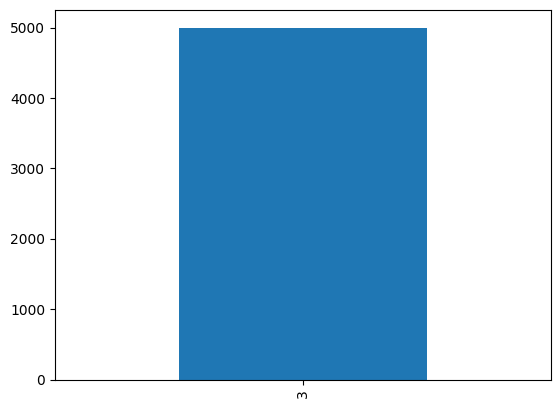

In [118]:
temp_df['Name'].str.split().map(len).value_counts().plot.bar()
print("(Max, Min, Mean)")
temp_df['Name'].str.split().map(len).max(), temp_df['Name'].str.split().map(len).min(), temp_df['Name'].str.split().map(len).mean()

# Generating Bad Names
generate individual full names:
- total garbage - 500
  - we can randomly shuffle the correct names
- mistype names - 500
  - repeat random characters
- other correct words but not names - 500
- mix of all of above - 500

### Helper functions 

### Generate names with repeated characters between 1, 2

In [119]:
def repeat_characters(name: str, num_repeats: int) -> str:
    """
    Repeat random characters for a num of repeats, randomly turned off(to reduce the number of repeats) so words are not recognizably long.
    """
    new_name: str = ""
    for idx, ch in enumerate(name):
        if random.randint(0, 1):
            reps = num_repeats
        else:
            reps = 1
        new_name += ch * random.randint(1, reps)
    
    return new_name

In [120]:
repeat_characters("مريم", 2)

'مرريم'

In [121]:
repeated_names = []
for name in names_df.iloc[:, 0].values:
    repeated_names.append(repeat_characters(name, 2))
    
repeated_names[:10]

['زههير',
 'صصفوحح',
 'عالييا',
 'برروج',
 'زاههى',
 'ننورة',
 'عبدالنافعع',
 'خللود',
 'مريم',
 'عابر']

### Get some random but correct words from the internet

In [122]:
df = pd.read_csv("data/ar_reviews_100k.tsv", sep="\t")
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [123]:
word_counter = Counter()

for sent in tqdm(df.iloc[:, 1], total=df.shape[0]):
    # remove Punctuation first
    sent = sent.translate(str.maketrans('', '', string.punctuation))
    word_counter.update(sent.split())

print(f"Number of words: {len(word_counter)}")
some_common_words = word_counter.most_common()[10_000: 15_000]
some_common_words = [i[0] for i in some_common_words]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99999/99999 [00:04<00:00, 24563.99it/s]

Number of words: 351992


### Total Garabage

In [124]:
garbage_names = []

for name in names_df.iloc[:, 0].values:
    name = list(name)
    random.shuffle(name)
    garbage_names.append("".join(name))
    
garbage_names[:10]

['هزير',
 'وفحص',
 'ايعلا',
 'جروب',
 'ىهاز',
 'رةنو',
 'داعفنابعل',
 'لدوخ',
 'رميم',
 'راعب']

## Generating Bad Names
- [x] total garbage
- [x] repeated
- [x] correct words but not names
- [x] mix bad names
- [x] mix good and bad names
    - 1 or 2 good names

In [125]:
def generate_mix(bad_names: List[str], good_names: List[str], num_names: int = 500) -> List[str]:
    """
    Generate 3-words names that have 1 or 2 correct names in it.
    """
    
    names = []
    for _ in range(num_names):
        # pick 1 or 2 good names
        num_good = random.randint(1, 2)
        num_bad = 3 - num_good

        name_words = []
        name_words.extend(random.sample(good_names, num_good)) # good names
        name_words.extend(random.sample(bad_names, num_bad)) # bad names
        random.shuffle(name_words)
        names.append(" ".join(name_words))
        
    return names

In [126]:
# garbage
n = ds_size//2//5

bad_names = []
bad_names.extend(generate_fullnames(garbage_names, num_names=n))

# repeated
bad_names.extend(generate_fullnames(repeated_names, num_names=n))

# correct but not names
bad_names.extend(generate_fullnames(some_common_words, num_names=n))

# mix bad names
bad_names.extend(generate_fullnames(garbage_names+repeated_names+some_common_words, num_names=n))

# mix good and bad names
bad_names.extend(generate_mix(garbage_names+repeated_names+some_common_words, correct_names, num_names=n))

print(f"Number of bad names: {len(bad_names)}")

Number of bad names: 5000


In [127]:
pd.DataFrame(bad_names, columns=["Name"]).to_csv("data/full_bad_names.csv", index=None)

In [128]:
temp_df = pd.read_csv("data/full_bad_names.csv")
temp_df.sample(5)

,Name
4203,هديل رحيمه يضعف
2577,تجيد مبعثرة يقدمون
4067,عبدلسلام حسين نضع
545,رهزهمت هماب سمةن
1765,الصصبااح مخخائيل ج


# Making the Dataset

In [129]:
df_correct = pd.read_csv("data/full_correct_names.csv")
df_incorrect = pd.read_csv("data/full_bad_names.csv")

In [130]:
full_df = df_correct.copy()
full_df['class'] = 1
full_df = pd.concat([full_df, df_incorrect], ignore_index=True)
full_df.fillna(0, inplace=True)
full_df

,Name,class
0,المرزوقى مرشد رناده,1.0
1,عبدالمهدى يا اوسامه,1.0
2,نافد موعاز نصيف,1.0
3,سيداحمد نائد كوثر,1.0
4,معزوز شحاتة محيى,1.0
...,...,...
9995,شفاء الصالحين رائد,0.0
9996,حجرا الغالى زمننا,0.0
9997,لقاء اللشرييفف والشعور,0.0
9998,نوال بهارص يعد,0.0


In [131]:
full_df.to_csv(f"data/{ds_name}.csv", index=False)
temp_df = pd.read_csv(f"data/{ds_name}.csv")
print(temp_df.shape)
temp_df.sample(5)

(10000, 2)


,Name,class
8205,سبنكا ققتؤح اللجارحى,0.0
5238,طنيب فدلااىن استادلا,0.0
5228,دخام سبايتىل وميرن,0.0
8647,ابايسرسن لاييىء اففيووننى,0.0
9244,بطل ونظيفه ذهاب,0.0
